<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/Car_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification using convolutional neural network

In [1]:
import pathlib
import tarfile
import os
import numpy as np
import tensorflow as tf

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Download and extract flower dataset

In [3]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

file = tarfile.open("flower_photos.tgz")
file.extractall()
file.close()

--2024-02-25 16:35:28--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   172MB/s    in 1.3s    

2024-02-25 16:35:29 (172 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [4]:
for dirpath, dirnames, filenames in os.walk("flower_photos"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 5 directories and 1 images in flower_photos
There are 0 directories and 898 images in flower_photos/dandelion
There are 0 directories and 641 images in flower_photos/roses
There are 0 directories and 633 images in flower_photos/daisy
There are 0 directories and 799 images in flower_photos/tulips
There are 0 directories and 699 images in flower_photos/sunflowers


In [5]:
data_dir = pathlib.Path("flower_photos")
class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


## Split dataset into train and validation sets

In [89]:
train_ds = tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="training",
              seed=123,
              image_size=(224, 224),
              batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [90]:
val_ds = tf.keras.utils.image_dataset_from_directory(
              data_dir,
              validation_split=0.2,
              subset="validation",
              seed=123,
              image_size=(224, 224),
              batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Visualize the images

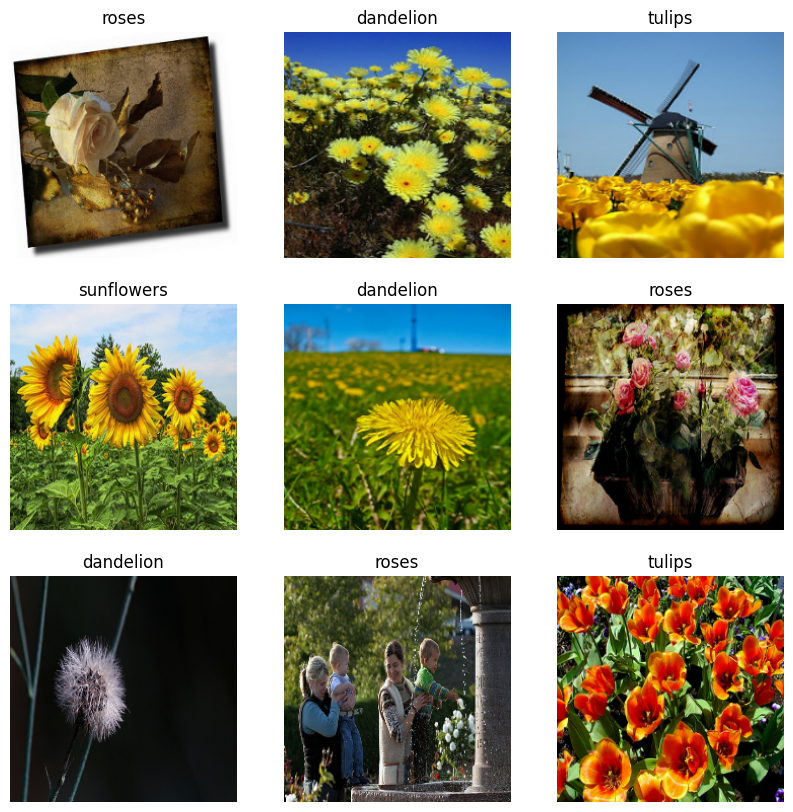

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Performance improvement by caching the datasets into memory

In [92]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a model

In [93]:
num_classes = len(class_names)

car_classification_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

car_classification_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=["accuracy"])

## Train the model

In [21]:
history_1 = car_classification_model.fit(train_ds, epochs=10, steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=len(val_ds))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 6s 35ms/step - loss: 1.4366 - accuracy: 0.4118 - val_loss: 1.1822 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 2s 25ms/step - loss: 1.1423 - accuracy: 0.5443 - val_loss: 1.1002 - val_accuracy: 0.5804
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 1.0683 - accuracy: 0.5787 - val_loss: 1.1066 - val_accuracy: 0.5872
Epoch 4/10
92/92 [==============================] - 2s 24ms/step - loss: 1.0123 - accuracy: 0.6100 - val_loss: 1.0750 - val_accuracy: 0.5913
Epoch 5/10
92/92 [==============================] - 2s 27ms/step - loss: 0.9687 - accuracy: 0.6277 - val_loss: 0.9837 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 2s 25ms/step - loss: 0.9230 - accuracy: 0.6482 - val_loss: 0.9635 - val_accuracy: 0.6431
Epoch 7/10
92/92 [==============================] - 2s 25ms/step - loss: 0.9020 - accuracy: 0.6597 - val_loss: 0.9339 - val_accuracy: 0.6431
Epoch 8/10
92/92 [======

## Evaluate the model

<Axes: >

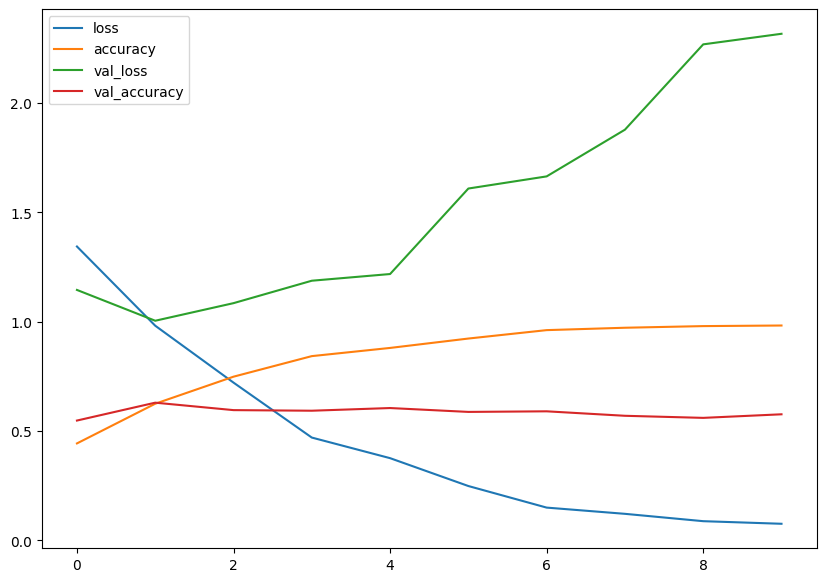

In [15]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10,7))

In [ ]:
# Loss for the model is reducing on the training data but loss-curve for validation is diverging in opposite direction, which probably means we are overfitting.
# There are few things that can be done to reduce the overfitting
# 1. Reduce the number of layers / neurons in the model
# 2. Perform data augmentation

In [ ]:
# Data Augmentation reduced the overfitting.

## Model 2

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 11s 88ms/step - loss: 1.4365 - accuracy: 0.3736 - val_loss: 1.2173 - val_accuracy: 0.4605
Epoch 2/20
92/92 [==============================] - 8s 87ms/step - loss: 1.1876 - accuracy: 0.4813 - val_loss: 1.1286 - val_accuracy: 0.5668
Epoch 3/20
92/92 [==============================] - 8s 87ms/step - loss: 1.1302 - accuracy: 0.5467 - val_loss: 1.1388 - val_accuracy: 0.5477
Epoch 4/20
92/92 [==============================] - 8s 86ms/step - loss: 1.0777 - accuracy: 0.5698 - val_loss: 1.0433 - val_accuracy: 0.5954
Epoch 5/20
92/92 [==============================] - 8s 85ms/step - loss: 1.0294 - accuracy: 0.5960 - val_loss: 0.9658 - val_accuracy: 0.6322
Epoch 6/20
92/92 [==============================] - 8s 85ms/step - loss: 0.9570 - accuracy: 0.6328 - val_loss: 0.9441 - val_accuracy: 0.6594
Epoch 7/20
92/92 [==============================] - 8s 84ms/step - loss: 0.9422 - accuracy: 0.6359 - val_loss: 0.8362 - val_accuracy: 0.6757
Epoch 8/20
92/92 [=====

<Axes: >

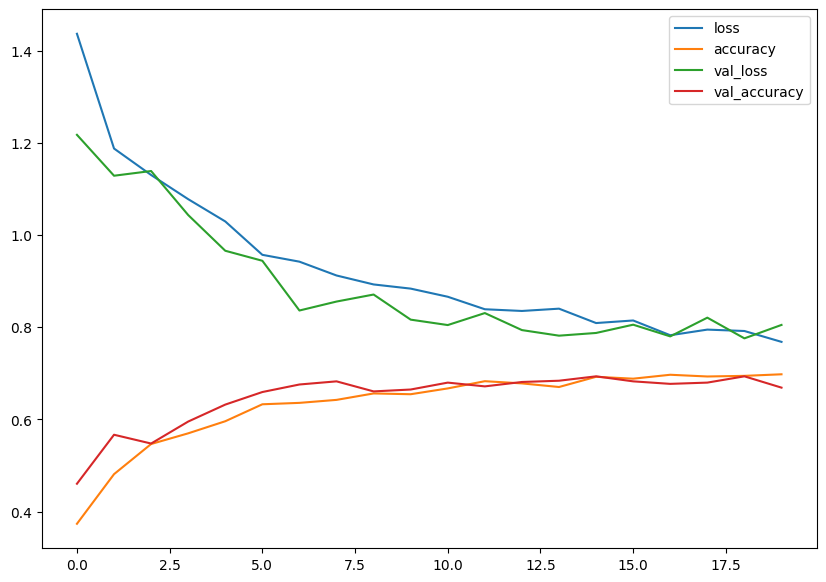

In [103]:
car_classification_model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

car_classification_model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=["accuracy"])

history_2 = car_classification_model2.fit(train_ds, epochs=20, steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=len(val_ds))
pd.DataFrame(history_2.history).plot(figsize=(10,7))

## Note -
Second model performance for both training and test dataset is acceptable. Need to check what the benchmark score for this model is.

In [104]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  img = img/255.
  return img


def pred_and_plot_multiclass(model, filename, class_names=class_names):
  image_file = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(image_file, axis=0))
  print(pred)
  print(class_names)
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  plt.imshow(image_file)
  plt.title(f"Predictions: {pred_class}")

1/1 [==============================] - 0s 82ms/step
[[0.1517096  0.5607549  0.18225136 0.08228134 0.02300288]]
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


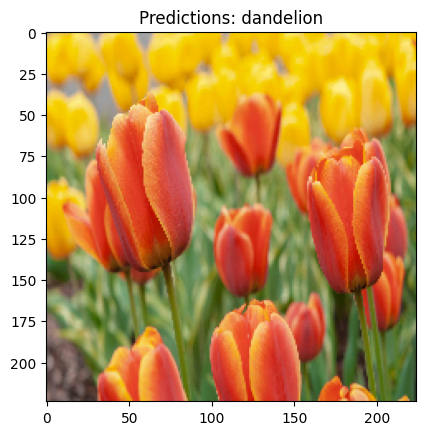

In [105]:
pred_and_plot_multiclass(car_classification_model2, "/content/tulips.jpg")

1/1 [==============================] - 0s 21ms/step
[[0.15156001 0.561022   0.18198612 0.08254328 0.02288864]]
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


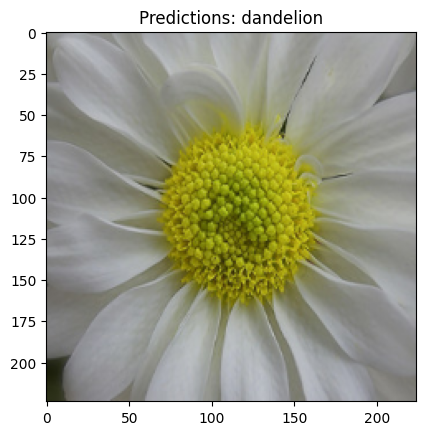

In [106]:
pred_and_plot_multiclass(car_classification_model2, "/content/100080576_f52e8ee070_n.jpg")

In [107]:
ds_labels = [labels for _, labels in val_ds.unbatch()]
y_true = np.array(ds_labels)
y_preds = car_classification_model2.predict(val_ds)
y_preds = np.array(tf.argmax(y_preds, axis=1))

23/23 [==============================] - 1s 23ms/step


In [108]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_preds)

array([[ 88,  27,   4,   1,   9],
       [  6, 141,   4,  11,  14],
       [ 10,  11,  61,   2,  36],
       [  7,  12,   2, 113,  18],
       [ 16,   9,  38,   6,  88]])